# Chapter 6

# Linear Model Selection and Regularization

Some ways in which linear model can be improved by replacing least squares fitting with some alternative fitting procedures. These alternative procedures will improve the prediction accuracy and model interpretibility.

__1. Prediction Accuracy__ :- Least square method is supposed to have low bias if the true model is linear and also if data is big enough it will have low variance as well. But if:

    (i). p > n, no least square solution exist.
    (ii). if n is not much larger than p, estimates will have higher variability and the model might overfit.
   By constraining ot shrinkage, we can reduce the variance with some negligible increase in bias.

__2. Model Interpretibility__ :- By setting irrelevant variables to zero, we can increase interpretibility of the model. Least square is unlikely to do that.


## 3 methods of model selection and regularization :-
__1. Best Subset Selection__:- Identifying a subset of p predictors that we believe related to response.

__2. Shrinkage__:- Fitting a model with all variables but they are shrunken towards zero relative to least squares. Shrinkage can also perform variable selection.

__3. Dimension Reduction__:- Projecting p predictors into M dimensional subspace, where M < p. This is done by taking M linear combination of the p variables.

## Subset Selection :-
Methods of selecting subset of predictors.

### 1. Best Subset Selection :-
Fit a seperate regression model for each combination of p predictors. Several stages of Best subset selection.
1. Start with $M_o$ i.e. a null model.
2. For k = 1,2,...p, Fit all $p \choose k$ models and pick the best among them and call them $M_0$ based on RSS or $R^2$.
3. Select a single best model from $M_0, M_1,......,M_p$ using cross validated prediction error, $C_p$, AIC, BIC or adjusted $R^2$.

Step 2 is reducing the problem from one of $2^p$ to one of (p+1) possible models. But as p increases, RSS decreases and $R^2$ increase so we will end up selecting model with maximum variable. We need to check performance of test data and hence come step 3.

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import statsmodels.api as sm
import random
import itertools
from sklearn.linear_model import Ridge

In [2]:
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Credit.csv"
Credit = pd.read_csv(url, index_col = 0)
variables = Credit.columns
variables = variables.drop("Balance")

In [17]:
results = []
for k in range(len(variables)):
    for subset in itertools.combinations(variables,k+1):
        all_columns = "+".join(list(subset))
        my_formula = "Balance~" + all_columns
        model = ols(formula = my_formula, data = Credit).fit()
        results.append({"RSS":model.mse_resid, "R_squared": model.rsquared,"Variable_count": k+1, 
                        'resid_sum': (model.resid ** 2).sum(), 'BIC': model.bic, 
                        'Adjusted_R2': model.rsquared_adj})
    print("Done for : ",k)
RSS_and_r2 = pd.DataFrame(results)
Min_RSS = RSS_and_r2.groupby(["Variable_count"])['RSS'].min().reset_index()
Max_R2 = RSS_and_r2.groupby(["Variable_count"])['R_squared'].max().reset_index()
Min_BIC = RSS_and_r2.groupby(["Variable_count"])['BIC'].min().reset_index()
Max_adj_R2 = RSS_and_r2.groupby(["Variable_count"])['Adjusted_R2'].max().reset_index()

Done for :  0
Done for :  1
Done for :  2
Done for :  3
Done for :  4
Done for :  5
Done for :  6
Done for :  7
Done for :  8
Done for :  9


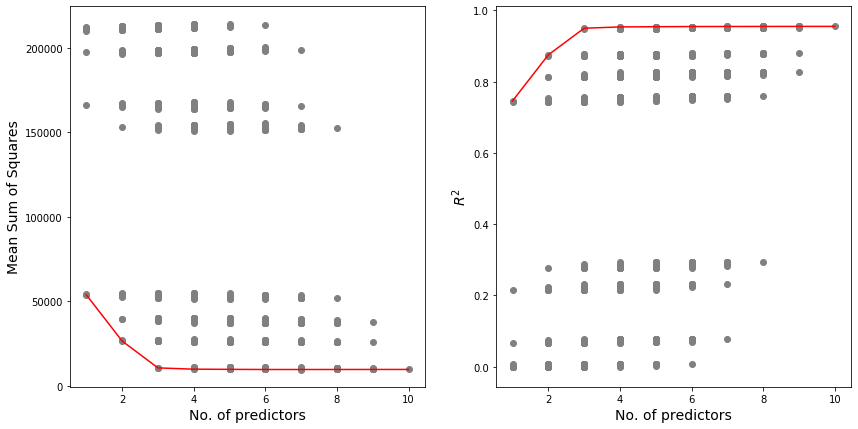

In [79]:
fig = plt.figure(figsize = (14,7))
ax1 = fig.add_subplot(121)
ax1.scatter(RSS_and_r2["Variable_count"], RSS_and_r2["RSS"], color = "grey")
ax1.plot(Min_RSS["Variable_count"], Min_RSS["RSS"], color = "r")
ax1.set_xlabel("No. of predictors", fontsize = 14)
ax1.set_ylabel("Mean Sum of Squares", fontsize = 14)
ax2 = fig.add_subplot(122)
ax2.scatter(RSS_and_r2["Variable_count"], RSS_and_r2["R_squared"], color = "grey")
ax2.plot(Max_R2["Variable_count"], Max_R2["R_squared"], color = "r")
ax2.set_xlabel("No. of predictors", fontsize = 14)
ax2.set_ylabel("$R^2$", fontsize = 14)
plt.show()

Above plot shows that, after adding 3 variables, there is little improvement in RSS and $R^2$ with each additional variable. So the subset of 3 variable with combination that gives minimum error can be used for model building.

For classification, instead of RSS or $R^2$, we can use deviance.

__Deviance__:- Negetive two times the maximized log-likelihood; smaller the deviance, better the fit. Deviance can be used for a broader class of models. 

__Drawbacks of Best Subset Selection__ :-
1. The drawback is that it can be computationally expensive if p is large.
2. When p is large, we have a big search space and hence more chances of selecting a model that is good at training but not on testing.

### 2. Stepwise Selection :-
Selecting a far more restricted set of variables.

__Forward Stepwise Selection__ :- 
1. Start with null model $M_o$.
2. For k = 0,1,2,.....,p-1. 
    
    (i). Consider all p-k models that augment the predictors in $M_k$ with one additional predictor.
    
    (ii). Choose the best among p-k models and call it $M_{k+1}$. Here best is defined as having smallest RSS or highest $R^2$.
    
3. Select a single model from $M_0, M_1, .... , M_p$ using cross validation error, $C_p$, AIC, BIC, etc.

Unlike Best subset selection, now we are considering only, 1 + p(p+1)/2 models.

__Drawbacks__:- 
1. Not guaranteed to find the best model.
2. If best one variable models has $X_1$, but best 2 variable model contain $X_2, X_3$, then forward selection will never select that model because 2 variable model will always have $X_1$.

__Advantage__:- Forward selection can be applied in high dimensional setting where n < p; however we can only construct $M_1,......,M_{n-1}$ only.

__Backward Stepwise Selection__ :- 
1. Start with null model $M_o$.
2. For k = p,p-1,....,1.
    
    (i). Consider all k models that contains all but one of the predictors in $M_k$ for a total of k-1 predictors
    
    (ii). Choose the best among these k models and call it $M_{k-1}$. Here best is defined as having smallest RSS or highest $R^2$.
    
3. Select a single model from $M_0, M_1, .... , M_p$ using cross validation error, $C_p$, AIC, BIC, etc.

Backward and Forward selection both have similar advantage and disadvantages. Both do not guarantee best subset and also do not give identical model.

__Hybrid Approach__:- To closely mimic best subset selection, we need to remove variable as well at each stage while adding.

### Choosing the best model 
In the above mentioned methods, in order to select the best model with respect to test error:
1. We can indirectly estimate test error by making an adjustment to the training error to account for the bias due to overfitting.
2. Estimate test error, using a validation set approach.

__$C_p$, AIC, BIC and adjusted $R^2$__ :-
To select between model with different no. of parameters, we can't use training RSS and training $R^2$ as they decrease with each adding variable even if that variable do not add any value.

But there are techniques to adjust training error for the model size available. Such as :-
1. __$C_p$__:- For fitted least squares model containing d predictors, the $C_p$ estimate of test MSE is 
$$C_p = \frac{1}{n}(RSS + 2d \hat\sigma^2)$$
where $\hat\sigma^2$ = estimate of variance of the error $\epsilon$. $\hat\sigma^2$ is estimated using full model containing all p predictors.

$C_p$ is adding a penalty of 2d$\hat\sigma^2$ to the training RSS in order to adjust for the fact that training error underestimates test error. As d increase, penalty increase.

$C_p$ is unbiased estimate of test error. Lower the $C_p$, better the model.

2. __AIC (Akaike Information Criteria)__ :- Defined for a large class of model fit by maximum likelihood. For least squares,
$$AIC = \frac{1}{n\hat\sigma^2} (RSS + 2d \hat\sigma^2).$$
For least squares, $C_p$ and AIC are proportional to each other.

3. __BIC (Bayesian Information Criteria)__ :- For least squares with p predictors,
$$BIC = \frac{1}{n\hat\sigma^2} (RSS + log(n)d \hat\sigma^2)$$

BIC replaces $2d \hat\sigma^2$ with $log(n)d \hat\sigma^2$, where n is no. of observations. For any n > 7, log(n) > 2, the BIC statistic generally places a heavier penalty on models with many variables, and hence result in models with less predictors.

4. __Adjusted $R^2$__ :- Since RSS always decrease as more variables are added to the model, the $R^2$ always increase.
$$Adj. R^2 = \frac{1 - RSS/(n-d-1)}{TSS/(n-1)}$$
Large Adj. $R^2$, better model.
Now as no. of variable increases, RSS/(n-d-1), may or may not increase due to the presence of d in denominator.
Adjusting $R^2$ prevents us to use noise variable.

In [61]:
# We will calculate Cp for Credit data.
sigma_sq = RSS_and_r2[RSS_and_r2['Variable_count']== 10]['resid_sum']/(len(Credit) - (len(variables)+1) -1)
RSS_and_r2["Cp"] = (RSS_and_r2['resid_sum'] + 2 * RSS_and_r2['Variable_count'] * sigma_sq.values)/len(Credit)
Min_Cp = RSS_and_r2.groupby(["Variable_count"])['Cp'].min().reset_index()

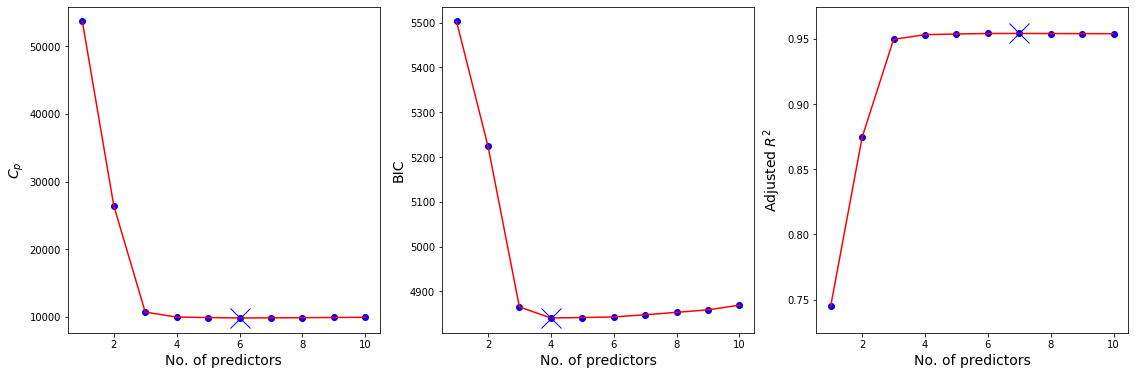

In [71]:
fig = plt.figure(figsize = (19,6))
ax1 = fig.add_subplot(131)
ax1.scatter(Min_Cp["Variable_count"], Min_Cp["Cp"], color = "b")
ax1.plot(Min_Cp["Variable_count"], Min_Cp["Cp"], color = "r")
ax1.plot(Min_Cp["Cp"].idxmin() + 1, Min_Cp["Cp"].min(), marker = "x", markersize = 20, color = 'b')
ax1.set_xlabel("No. of predictors", fontsize = 14)
ax1.set_ylabel("$C_p$", fontsize = 14)

ax2 = fig.add_subplot(132)
ax2.scatter(Min_BIC["Variable_count"], Min_BIC["BIC"], color = "b")
ax2.plot(Min_BIC["Variable_count"], Min_BIC["BIC"], color = "r")
ax2.plot(Min_BIC["BIC"].idxmin() + 1, Min_BIC["BIC"].min(), marker = "x", markersize = 20, color = 'b')
ax2.set_xlabel("No. of predictors", fontsize = 14)
ax2.set_ylabel("BIC", fontsize = 14)

ax3 = fig.add_subplot(133)
ax3.scatter(Max_adj_R2["Variable_count"], Max_adj_R2["Adjusted_R2"], color = "b")
ax3.plot(Max_adj_R2["Variable_count"], Max_adj_R2["Adjusted_R2"], color = "r")
ax3.plot(Max_adj_R2["Adjusted_R2"].idxmax() + 1, Max_adj_R2["Adjusted_R2"].max(), marker = "x", markersize = 20, color = 'b')
ax3.set_xlabel("No. of predictors", fontsize = 14)
ax3.set_ylabel("Adjusted $R^2$", fontsize = 14)

plt.show()

The above plot shows that all the 3 measure of model performance has a minimum value for different set of predictors (marked as blue). But the inspection of above plots also shows that all of them suggest that after 3 variable, improvement was not significant for each additional variable. So all of them will ultimately get us to select the same model.

__Validation and cross validation__

As an alternate to above methods, we can directly estimate test error using validation test and cross validation methods. If we have a lot of data, CV methods are always preferred.

* Also, validation approach make lesser assumptions about the true underlying methods.
* Validation set approach depends on how we split the data and would probably result in different selection of models. AIC, BIC, etc do not have that problem.

__One standard error rule__ :-
1. Calculate estimate of test error for each model size.
2. Select the model with smallest predictor set for which estimated test error is within one S.E. of lowest point on the curve. If a lot of model give similar estimate of test error, choose the simplest model.

## Shrinkage Methods 
We can fit a model with all the predictors but some of them are shrinked towards zero. Such a method can significantly reduce the variance of the model.

### Ridge Regression 
Ridge regression coefficient estimates $\beta^R$ are values that minimizes 
$$\sum_{i = 1}^{n}(y_i - \beta_0 - \sum_{j = 1}^{p}\beta_jx_{ij})^2 + \lambda \sum_{j = 1}^{p}\beta_{j}^{2} = RSS + \lambda \sum_{j = 1}^{p}\beta_{j}^{2}$$

where $\lambda \ge 0$ is a tuning parameter, to be determined seperately.

$\lambda \sum_{j = 1}^{p}\beta_{j}^{2}$ called shrinkage penalty. As we are minimizing it, so it has the effect of shrinking the estimates towards zero.

* For $\lambda = 0$, no effect of penalty.
* $\lambda -> \infty$, shrinkage penalty grows and coefficients approaches zero.
* Note that shrinkage do not apply to the intercept.
* Also, befor performing ridge we should scale the variable because in least squares multiplying the variable by a number results in scaling of coefficients as well and $X_j\beta_j$ remain same but not in ridge.

$X_j\beta_j^R$ not only depends on $\lambda$ but also on scaling of predictors(also on the scaling of other predictors).

$$x_{ij}^R = \frac{x_{ij}}{\sqrt{\frac{1}{n} \sum_{i = 1}^{n}(x_{ij} - \bar x_j)^2}}$$

In [20]:
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Credit.csv"
Credit = pd.read_csv(url, index_col = 0)
dummy = pd.get_dummies(Credit[['Gender','Student','Married','Ethnicity']]) # Creating dummies for categorical vars
Credit = pd.concat([Credit,dummy],axis = 1)
Credit.columns

Index(['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender',
       'Student', 'Married', 'Ethnicity', 'Balance', 'Gender_ Male',
       'Gender_Female', 'Student_No', 'Student_Yes', 'Married_No',
       'Married_Yes', 'Ethnicity_African American', 'Ethnicity_Asian',
       'Ethnicity_Caucasian'],
      dtype='object')

In [165]:
# Code for fitting ridge regression model for different values of lambda.
X = np.array(Credit.drop(['Balance','Gender','Student','Married','Ethnicity',
                          'Gender_ Male','Student_No','Married_No','Ethnicity_African American'], axis = 1))
y = np.array(Credit['Balance'])
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
lambda_range = 10**np.linspace(-2,5,100)
coef = []
for l in lambda_range:
    model = Ridge(alpha = l)
    model.fit(X,y)
    coef.append(list(model.coef_))
coef_df = pd.DataFrame(coef,columns = Credit.drop(['Balance','Gender','Student','Married','Ethnicity',
                          'Gender_ Male','Student_No','Married_No','Ethnicity_African American'], axis = 1).columns)
del coef

In [190]:
# Fitting a linear regression with out regularization
lm = LinearRegression()
lm.fit(X,y)
l2_norm_lm = np.sqrt(sum(map(lambda i: i*i,lm.coef_))) # l2 norm for linear regression
# l2 norm for Ridge regression coefficient corresponding to each lambda
coef_df_arr = np.array(coef_df)
l2_norm_ridge = [np.sqrt(sum(map(lambda i: i*i,beta))) for beta in coef_df_arr]
l2_norm_ratio = [i/l2_norm_lm for i in l2_norm_ridge]

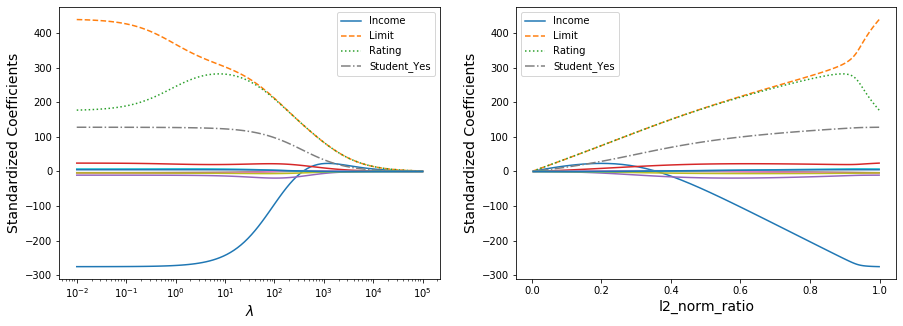

In [200]:
fig = plt.figure(figsize = (15,5))
# Plotting coefficients corresponding to lambdas
ax1 = fig.add_subplot(121)
linestyles = ['-', '--', ':', '-','-','-','-','-.','-','-','-']
for i,col in enumerate(coef_df.columns):
    if col in ['Income','Limit','Rating','Student_Yes'] :
        ax1.plot(lambda_range, coef_df[col], label = col, linestyle = linestyles[i])
    else:
        ax1.plot(lambda_range, coef_df[col],linestyle = linestyles[i])    
ax1.set_xscale('log')
ax1.set_xlabel("$\lambda$", fontsize = 14)
ax1.set_ylabel("Standardized Coefficients", fontsize = 14)
ax1.legend()

# Plotting coefficients corresponding to l2 norm ratio of ridge rigression and linear regression.
ax2 = fig.add_subplot(122)
linestyles = ['-', '--', ':', '-','-','-','-','-.','-','-','-']
for i,col in enumerate(coef_df.columns):
    if col in ['Income','Limit','Rating','Student_Yes'] :
        ax2.plot(l2_norm_ratio, coef_df[col], label = col, linestyle = linestyles[i])
    else:
        ax2.plot(l2_norm_ratio, coef_df[col], linestyle = linestyles[i])    
ax2.set_xlabel("l2_norm_ratio", fontsize = 14)
ax2.set_ylabel("Standardized Coefficients", fontsize = 14)
ax2.legend()
plt.show()

Above plot shows how with increasing value of $\lambda$, coefficients are converging towards zero. Also, increasing not necessarily decrease all the coefficients, as can be seen with Rating varaible. Some individial coefficients might increase as well. 2nd plot, x axis is $|| \hat \beta_{\lambda}^{R}||_2 / || \hat \beta ||_2$ which represents how much ridge regression coefficients have shrunken towards zero.

__Why ridge regression improves over least squares?__